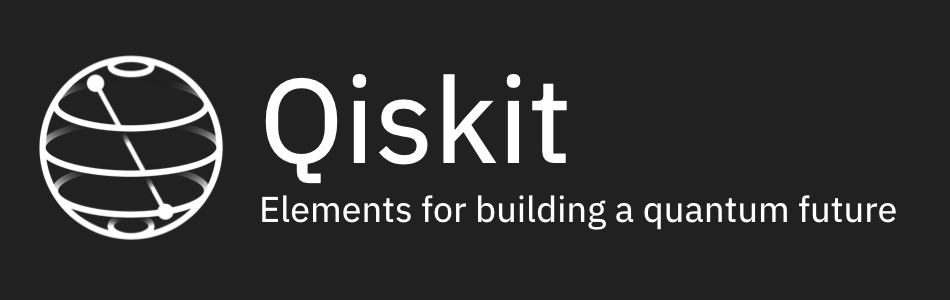

# Quantum State Tomography

This notebook contains examples for using the ``ignis.verification.tomography`` state tomography module.

In [1]:
# Needed for functions
import numpy as np
import time
from copy import deepcopy

# Import Qiskit classes
import qiskit 
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.quantum_info import state_fidelity
from qiskit.providers.aer import noise

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc

## 2-Qubit state tomography Example

In the below example we want to perform state tomography on a 2Q Bell state between qubits 3 and 5. To make the reference circuit we generate the expected statevector using ``statevector_simulator`` between qubits 0 and 1. 

In [2]:
# Create the expected density matrix
q2 = QuantumRegister(2)
bell = QuantumCircuit(q2)
bell.h(q2[0])
bell.cx(q2[0], q2[1])
print(bell)

job = qiskit.execute(bell, Aer.get_backend('statevector_simulator'))
psi_bell = job.result().get_statevector(bell)
print(psi_bell)

         ┌───┐     
q0_0: |0>┤ H ├──■──
         └───┘┌─┴─┐
q0_1: |0>─────┤ X ├
              └───┘
[0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


In [3]:
# Create the actual circuit 
q2 = QuantumRegister(6)
bell = QuantumCircuit(q2)
bell.h(q2[3])
bell.cx(q2[3], q2[5])
print(bell)

                   
q1_0: |0>──────────
                   
q1_1: |0>──────────
                   
q1_2: |0>──────────
         ┌───┐     
q1_3: |0>┤ H ├──■──
         └───┘  │  
q1_4: |0>───────┼──
              ┌─┴─┐
q1_5: |0>─────┤ X ├
              └───┘


Here we are going to generate and run the state tomography circuits. By only passing in the 2 registers we want to measure the state tomography will only run on that reduced $2^2$ Hilbert space. However, if we pass the whole register in the state tomography module will try and fit the full $2^6$ space.

In [4]:
# Generate circuits and run on simulator
t = time.time()
# Generate the state tomography circuits. Only pass in the 
# registers we want to measure (in this case 3 and 5)
qst_bell = state_tomography_circuits(bell, [q2[3],q2[5]])
job = qiskit.execute(qst_bell, Aer.get_backend('qasm_simulator'), shots=5000)
print('Time taken:', time.time() - t)

tomo_bell = StateTomographyFitter(job.result(), qst_bell)

Time taken: 0.08162879943847656


The fitter will output a density matrix ordered according to how we passed in the registers to ``state_tomography_circuits``. 

In [5]:
# Perform the tomography fit
# which outputs a density matrix
rho_bell = tomo_bell.fit()
F_bell = state_fidelity(psi_bell, rho_bell)
print('Fit Fidelity =', F_bell)

Fit Fidelity = 0.9998367586964225


### Repeat the Example with Measurement Noise

In [6]:
#Add measurement noise
noise_model = noise.NoiseModel()
for qi in range(6):
    read_err = noise.errors.readout_error.ReadoutError([[0.75, 0.25],[0.1,0.9]])
    noise_model.add_readout_error(read_err,[qi])
    
#generate the calibration circuits
meas_calibs, state_labels = mc.complete_meas_cal(qubit_list=[3,5])

backend = Aer.get_backend('qasm_simulator')
job_cal = qiskit.execute(meas_calibs, backend=backend, shots=15000, noise_model=noise_model)
job_tomo = qiskit.execute(qst_bell, backend=backend, shots=15000, noise_model=noise_model)

meas_fitter = mc.CompleteMeasFitter(job_cal.result(),state_labels)

tomo_bell = StateTomographyFitter(job_tomo.result(), qst_bell)

#no correction
rho_bell = tomo_bell.fit()
F_bell = state_fidelity(psi_bell, rho_bell)
print('Fit Fidelity (no correction) =', F_bell)

#correct data
correct_tomo_results = meas_fitter.filter.apply(job_tomo.result(), method='least_squares')
tomo_bell = StateTomographyFitter(correct_tomo_results, qst_bell)
rho_bell = tomo_bell.fit()
F_bell = state_fidelity(psi_bell, rho_bell)
print('Fit Fidelity (w/ correction) =', F_bell)

Fit Fidelity (no correction) = 0.571108210311232
Fit Fidelity (w/ correction) = 0.9905539409293663


## Generating and fitting random states

We now test the functions on the state generated by a circuit consisting of a layer of random single qubit unitaries u3.

In [7]:
def random_u3_tomo(nq, shots):
    
    def rand_angles():
        return tuple(2 * np.pi * np.random.random(3) - np.pi)
    q = QuantumRegister(nq)
    circ = QuantumCircuit(q)
    for j in range(nq):
        circ.u3(*rand_angles(), q[j])
    job = qiskit.execute(circ, Aer.get_backend('statevector_simulator'))
    psi_rand = job.result().get_statevector(circ)
    
    qst_circs = state_tomography_circuits(circ, q)
    job = qiskit.execute(qst_circs, Aer.get_backend('qasm_simulator'),
                         shots=shots)
    tomo_data = StateTomographyFitter(job.result(), qst_circs)
    rho_cvx = tomo_data.fit(method='cvx')
    rho_lstsq = tomo_data.fit(method='lstsq')
    
    print('F fit (CVX) =', state_fidelity(psi_rand, rho_cvx))
    print('F fit (LSTSQ) =', state_fidelity(psi_rand, rho_lstsq))

In [8]:
for j in range(5):
    print('Random single-qubit unitaries: set {}'.format(j))
    random_u3_tomo(3, 5000)

Random single-qubit unitaries: set 0
F fit (CVX) = 0.9970021426687093
F fit (LSTSQ) = 0.9938559982001989
Random single-qubit unitaries: set 1
F fit (CVX) = 0.9926241507480411
F fit (LSTSQ) = 0.9881044594933572
Random single-qubit unitaries: set 2
F fit (CVX) = 0.9986710986679923
F fit (LSTSQ) = 0.99990232375963
Random single-qubit unitaries: set 3
F fit (CVX) = 0.9942910810880954
F fit (LSTSQ) = 0.9911223098568922
Random single-qubit unitaries: set 4
F fit (CVX) = 0.9982499565955223
F fit (LSTSQ) = 0.9966482823050419


## 5-Qubit Bell State

In [9]:
# Create a state preparation circuit
q5 = QuantumRegister(5)
bell5 = QuantumCircuit(q5)
bell5.h(q5[0])
for j in range(4):
    bell5.cx(q5[j], q5[j + 1])

# Get ideal output state
job = qiskit.execute(bell5, Aer.get_backend('statevector_simulator'))
psi_bell5 = job.result().get_statevector(bell5)

# Generate circuits and run on simulator
t = time.time()
qst_bell5 = state_tomography_circuits(bell5, q5)
job = qiskit.execute(qst_bell5, Aer.get_backend('qasm_simulator'), shots=5000)

# Extract tomography data so that counts are indexed by measurement configuration
tomo_bell5 = StateTomographyFitter(job.result(), qst_bell5)
print('Time taken:', time.time() - t)

Time taken: 7.9116270542144775


In [10]:
t = time.time()
rho_lstsq_bell5 = tomo_bell5.fit(method='lstsq')
print('Least-Sq Reconstruction')
print('Time taken:', time.time() - t)
print('Fit Fidelity:', state_fidelity(psi_bell5, rho_lstsq_bell5))

Least-Sq Reconstruction
Time taken: 3.6655709743499756
Fit Fidelity: 0.9942473311097934


In [11]:
t = time.time()
rho_cvx_bell5 = tomo_bell5.fit(method='cvx')
print('CVX Reconstruction')
print('Time taken:', time.time() - t)
print('Fidelity:', state_fidelity(psi_bell5, rho_cvx_bell5))

CVX Reconstruction
Time taken: 39.63530111312866
Fidelity: 0.9999287186828141


## 2-Qubit Conditional State Tomography 

In this example, we have a three-qubit system where one of the qubits will be an ancilla for performing state tomography, i.e. only perform tomography when the third qubit is in the state "1". The circuit is setup in such a way that after conditional tomography we will get a Bell state on the first two qubits.

First make a 3Q GHZ state with no classical measurements.

In [12]:
# Create the actual circuit 
q2 = QuantumRegister(3)
ghz = QuantumCircuit(q2)
ghz.h(q2[0])
ghz.cx(q2[0], q2[1])
ghz.cx(q2[1], q2[2])
ghz.h(q2[2])
print(ghz)

         ┌───┐               
q9_0: |0>┤ H ├──■────────────
         └───┘┌─┴─┐          
q9_1: |0>─────┤ X ├──■───────
              └───┘┌─┴─┐┌───┐
q9_2: |0>──────────┤ X ├┤ H ├
                   └───┘└───┘


Here we are going to generate and run the state tomography circuits. Only pass the registers we want to perform state tomography on. The code will generate a new classical register for only those measurements.

In [13]:
qst_ghz = state_tomography_circuits(ghz, [q2[0],q2[1]])
print(qst_ghz[0])

         ┌───┐                ░ ┌───┐┌─┐   
q9_0: |0>┤ H ├──■─────────────░─┤ H ├┤M├───
         └───┘┌─┴─┐           ░ ├───┤└╥┘┌─┐
q9_1: |0>─────┤ X ├──■────────░─┤ H ├─╫─┤M├
              └───┘┌─┴─┐┌───┐ ░ └───┘ ║ └╥┘
q9_2: |0>──────────┤ X ├┤ H ├─░───────╫──╫─
                   └───┘└───┘ ░       ║  ║ 
 c8_0: 0 ═════════════════════════════╩══╬═
                                         ║ 
 c8_1: 0 ════════════════════════════════╩═
                                           


Now make a copy of this circuit (we will need it for the fitter) and make a new circuit with an ancilla measurement attached (this is what will be run):

In [14]:
#Make a copy without the ancilla register
qst_ghz_no_anc = deepcopy(qst_ghz)
ca = ClassicalRegister(1)
for qst_ghz_circ in qst_ghz:
    qst_ghz_circ.add_register(ca)
    qst_ghz_circ.measure(q2[2],ca[0])

In [15]:
#Run in Aer
job = qiskit.execute(qst_ghz, Aer.get_backend('qasm_simulator'), shots=10000)
raw_results = job.result()

Before sending the results to the state tomography fitter we must strip the register for the Q2 measurement and only keep the results when that register is 1.

In [16]:

new_result = deepcopy(raw_results)

for resultidx, _ in enumerate(raw_results.results):
    old_counts = raw_results.get_counts(resultidx)
    new_counts = {}
    
    #change the size of the classical register
    new_result.results[resultidx].header.creg_sizes = [new_result.results[resultidx].header.creg_sizes[0]]
    new_result.results[resultidx].header.clbit_labels = new_result.results[resultidx].header.clbit_labels[0:-1]
    new_result.results[resultidx].header.memory_slots = 2
    
    for reg_key in old_counts:
        reg_bits = reg_key.split(' ')
        if reg_bits[0]=='1':
            new_counts[reg_bits[1]]=old_counts[reg_key]

    new_result.results[resultidx].data.counts = \
        new_result.results[resultidx]. \
        data.counts.from_dict(new_counts)


In [17]:
tomo_bell = StateTomographyFitter(new_result, qst_ghz_no_anc)
# Perform the tomography fit
# which outputs a density matrix
rho_bell = tomo_bell.fit()

In [18]:
np.around(rho_bell,3)

array([[ 0.494+0.j   , -0.003+0.002j, -0.001+0.j   , -0.5  +0.003j],
       [-0.003-0.002j,  0.   +0.j   ,  0.   +0.j   ,  0.003+0.002j],
       [-0.001-0.j   ,  0.   -0.j   ,  0.   +0.j   ,  0.001+0.j   ],
       [-0.5  -0.003j,  0.003-0.002j,  0.001-0.j   ,  0.506+0.j   ]])

In [19]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright